In [17]:
import torch
import torch.nn as nn


D = nn.Sequential(
    nn.Linear(784, 128), 
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid())

G = nn.Sequential(
    nn.Linear(100, 128), 
    nn.ReLU(),
    nn.Linear(128, 784), 
    nn.Tanh())

criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.01)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.01)

while True:
    # train D
    loss = criterion(D(x), 1) + criterion(D(G(z)), 0)
    loss.backward()
    d_optimizer.step()
    
    #train G
    loss = criterion(D(G(z)), 1)
    loss.backward()
    g_optimizer.step()
    
    

---

In [21]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from model_utils import Discriminator, Generator

In [30]:
# hyperparameters
lr = 0.0002
batch_size = 32
image_size = 64 # 28x28 --> 64 x 64
channels_img = 1
channels_noise = 100
num_epochs = 10

# set this to 64 
features_d = 16
features_g = 16 

my_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    ])

dataset = datasets.MNIST(root = 'dataset/', train = True, transform = my_transforms, download = True)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create discrimator and generator
netD = Discriminator(channels_img, features_d).to(device)
netG = Generator(channels_noise, channels_img, features_g).to(device)

# Setup optimizer for G and D
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (0.5, 0.999))

netG.train()
netD.train()

criterion = nn.BCELoss()

real_label = 1
fake_label = 0

fixed_noise = torch.randn(64, channels_noise, 1, 1).to(device)
writer_real = SummaryWriter(f'runs/GAN_MNIST/test_real')
writer_fake = SummaryWriter(f'runs/GAN_MNIST/test_fake')

print("Starting Training...")

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.shape[0]
        
        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        label = (torch.ones(batch_size)*0.9).to(device) # send in real images
        output = netD(data).reshape(-1) # make it into one long vector
        lossD_real = criterion(output, label)
        D_x = output.mean().item() # compute mean confidence of discriminator; for printing values
        
        noise = torch.randn(batch_size, channels_noise, 1, 1).to(device)
        fake = netG(noise) 
        label = (torch.ones(batch_size)*0.1).to(device) #  
        
        output = netD(fake.detach()).reshape(-1) # want to backpropagate only on D
        lossD_fake = criterion(output, label)
        
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # Train Generator  : max log(D(G(z))) ; want D to see G(z) as 1
        netG.zero_grad()
        label = torch.ones(batch_size).to(device)
        output = netD(fake).reshape(-1) # use the same fakes 
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)}  Loss D: {lossD:.4f},loss G: {lossG:.4f} D(x): {D_x:.4f}')
            
            with torch.no_grad():
                fake = netG(fixed_noise)
                
                img_grid_real = torchvision.utils.make_grid(data[:32], normalize = True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize = True)
                writer_real.add_image('Mnist Real Images', img_grid_real)
                writer_fake.add_image('Mnist Fake Images', img_grid_fake)
        
        

Starting Training...
Epoch [0/10] Batch 0/1875  Loss D: 1.3853,loss G: 0.8789 D(x): 0.5863
Epoch [0/10] Batch 100/1875  Loss D: 0.6732,loss G: 3.3026 D(x): 0.8899
Epoch [0/10] Batch 200/1875  Loss D: 0.6876,loss G: 2.0556 D(x): 0.8303
Epoch [0/10] Batch 300/1875  Loss D: 0.7470,loss G: 2.8312 D(x): 0.9096
Epoch [0/10] Batch 400/1875  Loss D: 0.7595,loss G: 1.9524 D(x): 0.8173
Epoch [0/10] Batch 500/1875  Loss D: 0.8125,loss G: 1.9747 D(x): 0.8305
Epoch [0/10] Batch 600/1875  Loss D: 0.7404,loss G: 1.9611 D(x): 0.7893
Epoch [0/10] Batch 700/1875  Loss D: 0.6852,loss G: 2.1882 D(x): 0.8599
Epoch [0/10] Batch 800/1875  Loss D: 0.7503,loss G: 2.3047 D(x): 0.8263
Epoch [0/10] Batch 900/1875  Loss D: 0.7645,loss G: 1.4695 D(x): 0.7558
Epoch [0/10] Batch 1000/1875  Loss D: 0.8818,loss G: 2.5345 D(x): 0.8981
Epoch [0/10] Batch 1100/1875  Loss D: 1.3606,loss G: 1.7132 D(x): 0.3937
Epoch [0/10] Batch 1200/1875  Loss D: 0.9365,loss G: 2.3072 D(x): 0.9234
Epoch [0/10] Batch 1300/1875  Loss D: 0.97

In [156]:
a 

array([[0.01186858, 0.01504469, 0.00237228, ..., 0.00383481, 0.01782244,
        0.01570198],
       [0.00630767, 0.0120104 , 0.01232817, ..., 0.00480738, 0.00916964,
        0.0150037 ],
       [0.00280238, 0.03845676, 0.01495521, ..., 0.00159473, 0.01237783,
        0.01397348],
       ...,
       [0.0212563 , 0.01755095, 0.0146403 , ..., 0.00640761, 0.01938153,
        0.01552642],
       [0.00546663, 0.01324917, 0.01758071, ..., 0.00684669, 0.00805222,
        0.01543531],
       [0.00447697, 0.01140816, 0.01525133, ..., 0.00523173, 0.00451857,
        0.00936048]], dtype=float32)

In [663]:
a = img_fake[0].cpu().detach().numpy()

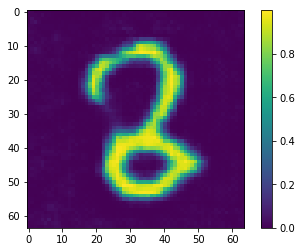

In [667]:
plt.imshow(a)
plt.colorbar()

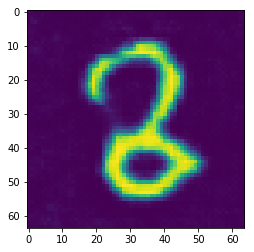

In [155]:
noise = torch.randn(batch_size, channels_noise, 1, 1).to(device)
fake1 = netG(noise) 
img_fake = torchvision.utils.make_grid(fake1[:1], normalize = True)
a = img_fake[0].cpu().detach().numpy()
plt.imshow(a)

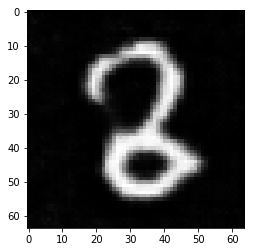

In [158]:
plt.imshow(a, cmap='gray')

#### 노이즈 추가해도 잘 된다!

---

#### 네트워크 만들기 위한 모듈

In [ ]:
nn.Conv2d
[[], 'LR', 'R', 'BN']

In [711]:
# f, k, s, p
# output feature_map, kernel, stride, padding
def make_layers_vanilla(cfg, kw = 'D', channel_noise = 100):
    layers = []
    in_channels = 3
    if kw == 'D': 
        for items in cfg:
            if 'LR' in items:
                layers += [nn.LeakyReLU(0.2)]
            elif 'BN' in items: 
                layers += [nn.BatchNorm2d(in_channels)]
            else:           
                conv2d = nn.Conv2d(in_channels, out_channels = items[0], kernel_size=items[1], 
                                  stride = items[2], padding = items[3])
                layers += [conv2d]
                in_channels = items[0]      
        layers += [nn.Sigmoid()]
    if kw == 'G':
        in_channels = channel_noise
        for items in cfg:
            if 'R' in items:
                layers += [nn.ReLU()]
            elif 'BN' in items: 
                layers += [nn.BatchNorm2d(in_channels)]
            else:           
                deconv2d = nn.ConvTranspose2d(in_channels, out_channels = items[0], kernel_size=items[1], 
                                  stride = items[2], padding = items[3])
                layers += [deconv2d]
                in_channels = items[0]
        layers += [nn.Tanh() ]
    return nn.Sequential(*layers)        

In [705]:
# f, k, s, p
# output feature_map, kernel, stride, padding
# features = 
cfg_256 =  {
    'D_1' : [ [64, 4, 2, 1],'LR', [64, 4, 2, 1], 'BN', 'LR', [128, 4, 2, 1], 'BN', 'LR',
             [128, 4, 2, 1],'BN', 'LR',[256, 4, 2, 1],'BN', 'LR', [512, 4, 2, 1], 
             'BN', 'LR',[1, 4, 2, 0] ] ,
    'G_1' :[ [1024, 4, 1, 0], 'BN', 'R', [512, 4, 2, 1], 'BN', 'R',  [256, 4, 2, 1], 'BN', 'R',  
            [256, 4, 2, 1], 'BN', 'R', [128, 4, 2, 1], 'BN', 'R', [64, 4, 2, 1], 
            'BN', 'R', [3, 4, 2, 1] ]
} 

In [714]:
make_layers_vanilla(cfg_256['G_1'], 'G')

Sequential(
  (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2)

In [727]:
make_layers_vanilla(cfg_256['D_1'], 'D')

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): LeakyReLU(negative_slope=0.2)
  (14): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (

In [746]:
class D_vanilla(nn.Module):
    def __init__(self, features):
        super(D_vanilla, self).__init__()
        self.features = features
        self.net = nn.Sequential()
    
    def forward(self, x):
        x = self.features(x)
        return x

class G_vanilla(nn.Module):
    def __init__(self, features):
        super(G_vanilla, self).__init__()
        self.features = features
        self.net = nn.Sequential()
    
    def forward(self, x):
        x = self.features(x)
        return x
    

In [747]:
def buildNet_vaniila(cfg, kw):
    if kw == 'D':
        return D_vanilla(make_layers_vanilla(cfg, kw))
    if kw == 'G':
        return G_vanilla(make_layers_vanilla(cfg, kw))

In [748]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baselineD = buildNet_vaniila(cfg_256['D_1'], kw = 'D').to(device)
baselineG = buildNet_vaniila(cfg_256['G_1'], kw = 'G').to(device)

In [750]:
from torchsummary import summary
summary(baselineD, input_size = (3, 256,256), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3           [-1, 64, 64, 64]          65,600
       BatchNorm2d-4           [-1, 64, 64, 64]             128
         LeakyReLU-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 32, 32]         131,200
       BatchNorm2d-7          [-1, 128, 32, 32]             256
         LeakyReLU-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 16, 16]         262,272
      BatchNorm2d-10          [-1, 128, 16, 16]             256
        LeakyReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12            [-1, 256, 8, 8]         524,544
      BatchNorm2d-13            [-1, 256, 8, 8]             512
        LeakyReLU-14            [-1, 25

In [755]:
summary(baselineG, input_size = (100,1,1), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 256, 32, 32]       1,048,832
      BatchNorm2d-11          [-1, 256, 32, 32]             512
             ReLU-12          [-1, 256, 32, 32]               0
  ConvTranspose2d-13          [-1, 128, 64, 64]         524,416
      BatchNorm2d-14          [-1, 128,